# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 6 de Junio. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime, os
import math

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


### Carga de datos

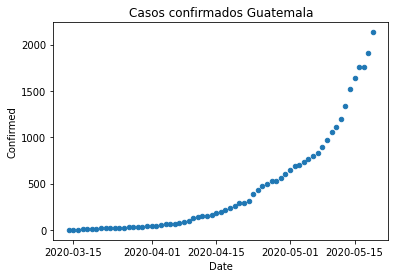

In [3]:
covid_data = pd.read_csv('covid_19_clean_complete.csv')
covid_data["Date"] = pd.to_datetime(covid_data["Date"],infer_datetime_format = True)
covid_data.head()

GT_confirmed = covid_data[(covid_data["Country/Region"] == 'Guatemala') & (covid_data["Confirmed"] > 0)].copy()
GT_confirmed.plot.scatter(x = "Date",y="Confirmed", title='Casos confirmados Guatemala')

Aplicamos logaritmo natural a los datos para obtener algo más parecido a un comportamiento lineal

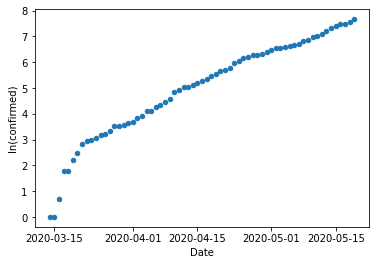

In [4]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Date",y="ln(confirmed)")

Removemos los datos de los días previos al 23 de marzo, donde la tendencia lineal todavía no aparece claramente, para evitar ruido en el modelo. También convertimos la fecha al número de días desde el 22 de marzo.

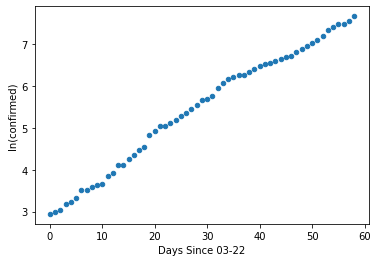

In [5]:
GT_confirmed_post24 = GT_confirmed.copy()[GT_confirmed.Date >= '2020-03-22']
GT_confirmed_post24["Days Since 03-22"] = np.arange(len(GT_confirmed_post24))
GT_confirmed_post24.plot.scatter(x = "Days Since 03-22",y="ln(confirmed)")

## Modelo de regresión lineal en TF (adaptado de la tarea anterior)

In [6]:
class SimpleLinearRegression:
    def __init__(self, x, y):
        self.x = x.reshape(-1, 1)
        self.y = y.reshape(-1, 1)
        self.weights = None
        self.error = None
        self.epochs = None 
        self.lr = None
        self.print_rate = None
        
    def train(self, epochs, lr, print_rate=200):
        self.print_rate = print_rate
        self.epochs = epochs
        self.lr = lr

        g = tf.Graph()
        with g.as_default():
            return self.__do_train()
    
    def __do_train(self):
        n_sample = len(self.x)
        placeholder_x = tf.placeholder(tf.float64, [n_sample, 1], "x")
        placeholder_y = tf.placeholder(tf.float64, [n_sample, 1], "y")
        feed = { placeholder_x: self.x, placeholder_y: self.y }

        with tf.Session() as session:    
            (weights_op, error_op) = self.__gradient_descent(placeholder_x, placeholder_y, self.lr)
            self.before_training(session.graph, weights_op, error_op)
            session.run(tf.global_variables_initializer())

            for epoch in range(1, self.epochs + 1):
                out = session.run([weights_op, error_op], feed)
                self.error = out[1]
                self.weights = out[0]
                
                self.after_epoch(epoch)
                if math.isinf(self.error):
                    print("terminando por divergencia")
                    break

            session.close()
        return self.weights, self.error
        
    def __gradient_descent(self, x, y, lr):
        n_samples = x.shape[0]
        n_independent_vars = x.shape[1] + 1 # contando el intercepto

        ones = tf.ones([n_samples, 1], tf.float64)
        x = tf.concat([x, ones], axis = 1)

        initial_weights = tf.zeros([n_independent_vars, 1], tf.float64)
        weights = tf.Variable(name="Weights", initial_value=initial_weights)

        y_hat = tf.matmul(x, weights)
        error = 1/2 * tf.reduce_mean(tf.math.square(y - y_hat))
        gradients = tf.gradients(error, weights)
        adjustment = tf.scalar_mul(-lr, gradients[0])
        weights = tf.assign(weights, (tf.add(weights, adjustment))) 
        return (weights, error)
    
    def after_epoch(self, epoch):
        if epoch % self.print_rate == 0 or epoch == self.epochs:
            print("epoch:" + str(epoch) + " error: " + str(self.error))
    
    def before_training(self, graph, weights_op, error_op):
        # overridear para inicializar tensorboard, etc
        pass



## Predicción de casos confirmados
A continuación se entrena el modelo definido arriba para obtener los pesos correspondientes a $m$ y $b$, luego realizamos la predicción para el 6 de junio, calculando el producto punto entre el vector de pesos y $[76, 1]$, (ya que pasaron 76 días desde el 22 de marzo), finalmente aplicamos la función exponencial, para revertir la transformación que hicimos al inicio.

In [7]:
x = GT_confirmed_post24["Days Since 03-22"].to_numpy()
y = GT_confirmed_post24["ln(confirmed)"].to_numpy()
model = SimpleLinearRegression(x, y)

weights, error = model.train(14000, 0.0015, 3000)
weights = weights.reshape(1,-1)


epoch:3000 error: 0.1323085228294766
epoch:6000 error: 0.024471669559754113
epoch:9000 error: 0.013731397621347865
epoch:12000 error: 0.012661694288829507
epoch:14000 error: 0.012568793563141563


In [8]:
def predict_confirmed_since_march_22(elapsed_days):
    return int(np.exp(np.dot(weights, np.array([elapsed_days, 1])))[0]) 

prediccion = predict_confirmed_since_march_22(76)
print("se predicen", prediccion, "casos para el 6 de junio (76 días desde el día 0)")


se predicen 11399 casos para el 6 de junio (76 días desde el día 0)


### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [9]:
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import PolynomialFeatures
sb.set()

In [10]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [11]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Tomaremos 15 vinos aleatoriamente de la muestra (~10%) como set de prueba para probar la precisión del modelo. Para asegurar que siempre sean los mismos, generaremos un arreglo de índices y lo dejaremos hardcodeado en el notebook.

In [12]:
# generados con np.random.randint(1599, size=15)
test_indices = [1057, 1262,  947,  808,  251,  562,  866, 1284, 1337, 6, 1071,  645,  787, 1338,  175]

if len(data) == 1599: # solo una vez!
    test_data = data.iloc[test_indices]
    data = data.drop(data.index[test_indices])

print("test rows", len(test_data))
print("training rows", len(data))


test rows 15
training rows 1584


## Análisis exploratorio de datos

Buscamos valores faltantes

In [13]:
data.isnull().values.any()


False

In [14]:
data.describe().drop(['count']).T

,mean,std,min,25%,50%,75%,max
fixed acidity,8.325758,1.744565,4.60000,7.1000,7.90000,9.20000,15.90000
volatile acidity,0.527895,0.179594,0.12000,0.3900,0.52000,0.64000,1.58000
citric acid,0.271793,0.194929,0.00000,0.0900,0.26000,0.42250,1.00000
residual sugar,2.536395,1.405213,0.90000,1.9000,2.20000,2.60000,15.50000
chlorides,0.087466,0.047219,0.01200,0.0700,0.07900,0.09000,0.61100
free sulfur dioxide,15.849747,10.458420,1.00000,7.0000,13.50000,21.00000,72.00000
total sulfur dioxide,46.462753,32.917471,6.00000,22.0000,38.00000,62.00000,289.00000
density,0.996748,0.001889,0.99007,0.9956,0.99675,0.99783,1.00369
pH,3.311351,0.154726,2.74000,3.2100,3.31000,3.40000,4.01000
sulphates,0.658510,0.169831,0.33000,0.5500,0.62000,0.73000,2.00000


## Histogramas

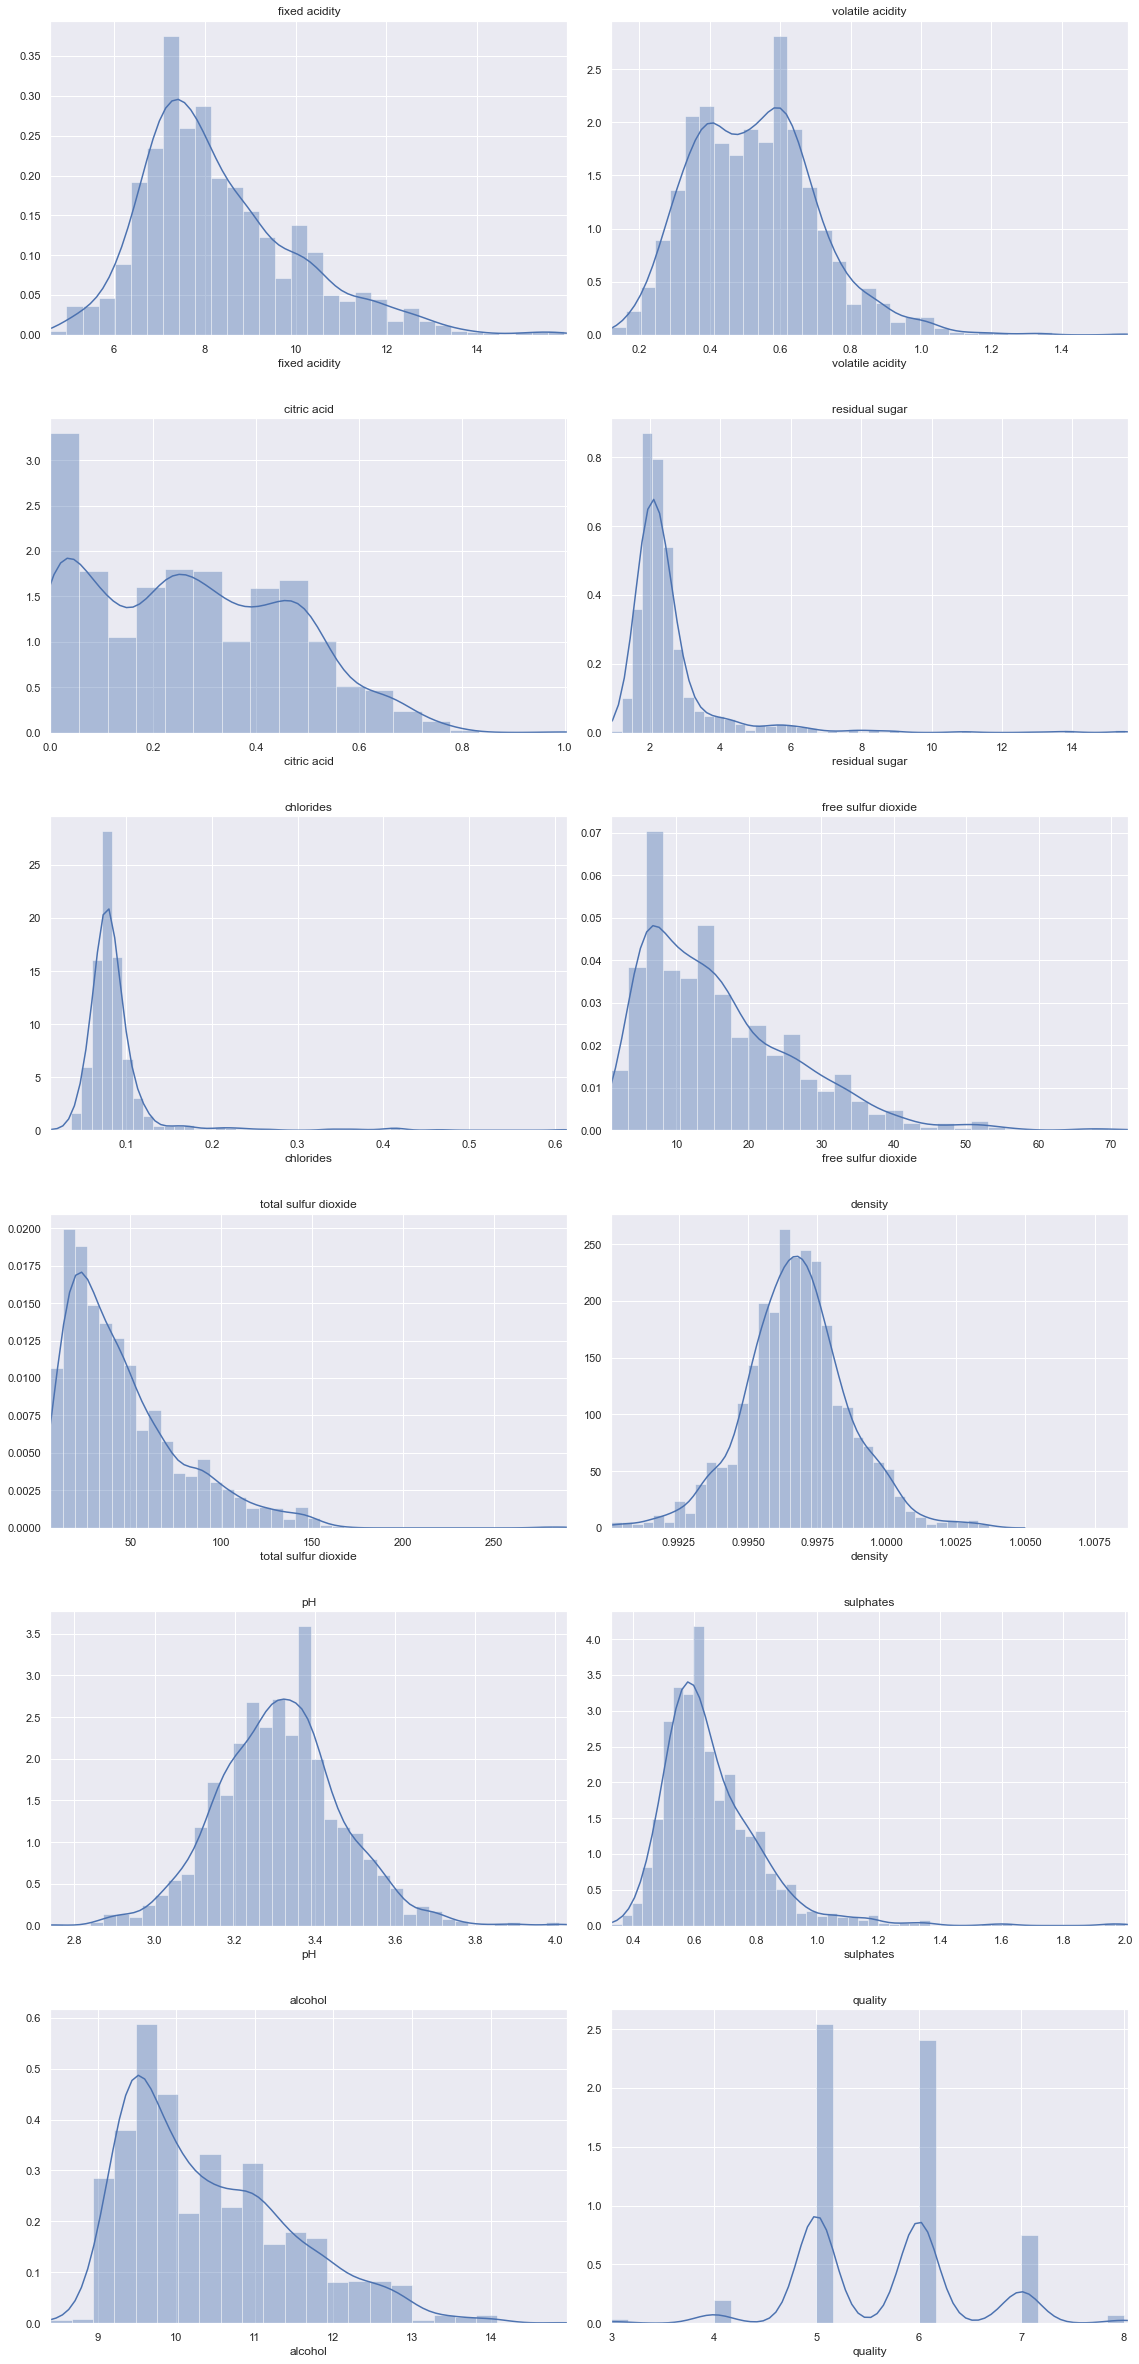

In [15]:
n = len(data.columns)
cols = 2
rows = n // cols
fig,ax = plt.subplots(rows, cols, figsize=(16,n*2.75))

i = 0
for col_name in data:
    current_ax = ax[i // cols][i % cols]
    current_ax.set_title(col_name)

    values = data[col_name]
    current_ax.set_xlim(np.min(values), np.max(values) * 1.005)
    sb.distplot(values,  ax=current_ax)
    i += 1

fig.tight_layout(h_pad=3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5
10,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5


In [48]:
import matplotlib
colormap = matplotlib.cm.get_cmap('PiYG')
single_var_corr = data.corr()
single_var_corr.style.background_gradient(cmap=colormap, vmin=-1, vmax=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.257319,0.671165,0.115613,0.093406,-0.156589,-0.116402,0.668733,-0.683960,0.183361,-0.064025,0.123069
volatile acidity,-0.257319,1.000000,-0.553981,-0.002313,0.061134,-0.011278,0.075471,0.018850,0.235716,-0.262328,-0.200952,-0.392212
citric acid,0.671165,-0.553981,1.000000,0.144501,0.204165,-0.063868,0.032983,0.366297,-0.542271,0.313737,0.106466,0.225989
residual sugar,0.115613,-0.002313,0.144501,1.000000,0.053885,0.186202,0.201480,0.353112,-0.083910,0.005731,0.045150,0.012621
chlorides,0.093406,0.061134,0.204165,0.053885,1.000000,0.006663,0.047958,0.199654,-0.264891,0.370535,-0.221587,-0.130051
free sulfur dioxide,-0.156589,-0.011278,-0.063868,0.186202,0.006663,1.000000,0.665639,-0.025534,0.075682,0.054640,-0.065520,-0.046131
total sulfur dioxide,-0.116402,0.075471,0.032983,0.201480,0.047958,0.665639,1.000000,0.067226,-0.062337,0.045151,-0.203477,-0.182585
density,0.668733,0.018850,0.366297,0.353112,0.199654,-0.025534,0.067226,1.000000,-0.340679,0.148908,-0.496875,-0.176407
pH,-0.683960,0.235716,-0.542271,-0.083910,-0.264891,0.075682,-0.062337,-0.340679,1.000000,-0.199034,0.204575,-0.060037
sulphates,0.183361,-0.262328,0.313737,0.005731,0.370535,0.054640,0.045151,0.148908,-0.199034,1.000000,0.092248,0.250944


* Variables relacionadas
    * fixed acidity y citric acid
    * fixed acidity y density
    * fixed acidity y pH
    * total sulfur dioxide y free sulfur dioxide
* Variables que no se ven muy relevantes
    * chlorides
    * free sulfur dioxide
    * pH
    * residual sugar?

In [58]:
feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', \
      'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']
x = data[feature_names]
y = data[['quality']]
x.shape

poly = PolynomialFeatures(2)
features = poly.fit_transform(x)
poly_feature_names = poly.get_feature_names(feature_names)

In [47]:
degree2_feats = features[:, 8:]
degree2_names = poly_feature_names[8:].copy()
degree2_names.append('quality')
degree2_feats_and_y = np.hstack((degree2_feats, y))

deg2_df = pd.DataFrame(data=degree2_feats_and_y, columns=degree2_names)
deg2_df.corr()['quality'].to_frame().T.style.background_gradient(cmap=colormap, vmin=-1, vmax=1)

,fixed acidity^2,fixed acidity volatile acidity,fixed acidity citric acid,fixed acidity chlorides,fixed acidity total sulfur dioxide,fixed acidity sulphates,fixed acidity alcohol,volatile acidity^2,volatile acidity citric acid,volatile acidity chlorides,volatile acidity total sulfur dioxide,volatile acidity sulphates,volatile acidity alcohol,citric acid^2,citric acid chlorides,citric acid total sulfur dioxide,citric acid sulphates,citric acid alcohol,chlorides^2,chlorides total sulfur dioxide,chlorides sulphates,chlorides alcohol,total sulfur dioxide^2,total sulfur dioxide sulphates,total sulfur dioxide alcohol,sulphates^2,sulphates alcohol,alcohol^2,quality
quality,0.127325,-0.319078,0.219300,-0.074986,-0.167438,0.247721,0.314806,-0.369958,0.044773,-0.296049,-0.277515,-0.187346,-0.263633,0.215954,0.031899,-0.035335,0.241676,0.291365,-0.092069,-0.222870,-0.041374,-0.047949,-0.140852,-0.103932,-0.113274,0.170901,0.411883,0.471440,1.000000


In [49]:
single_var_corr['quality'].to_frame().T.style.background_gradient(cmap=colormap, vmin=-1, vmax=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
quality,0.123069,-0.392212,0.225989,0.012621,-0.130051,-0.046131,-0.182585,-0.176407,-0.060037,0.250944,0.474283,1.000000


In [57]:
########################################
feature_names = data.columns[:-1].to_list()
x = data[feature_names]
features = poly.fit_transform(x)
poly_feature_names = poly.get_feature_names(feature_names)

In [56]:
degree2_feats = features[:, 12:]
degree2_names = poly_feature_names[12:].copy()
degree2_names.append('quality')
degree2_feats_and_y = np.hstack((degree2_feats, y))

deg2_df = pd.DataFrame(data=degree2_feats_and_y, columns=degree2_names)
deg2_df.corr()['quality'].to_frame().T.style.background_gradient(cmap=colormap, vmin=-1, vmax=1)

,fixed acidity^2,fixed acidity volatile acidity,fixed acidity citric acid,fixed acidity residual sugar,fixed acidity chlorides,fixed acidity free sulfur dioxide,fixed acidity total sulfur dioxide,fixed acidity density,fixed acidity pH,fixed acidity sulphates,fixed acidity alcohol,volatile acidity^2,volatile acidity citric acid,volatile acidity residual sugar,volatile acidity chlorides,volatile acidity free sulfur dioxide,volatile acidity total sulfur dioxide,volatile acidity density,volatile acidity pH,volatile acidity sulphates,volatile acidity alcohol,citric acid^2,citric acid residual sugar,citric acid chlorides,citric acid free sulfur dioxide,citric acid total sulfur dioxide,citric acid density,citric acid pH,citric acid sulphates,citric acid alcohol,residual sugar^2,residual sugar chlorides,residual sugar free sulfur dioxide,residual sugar total sulfur dioxide,residual sugar density,residual sugar pH,residual sugar sulphates,residual sugar alcohol,chlorides^2,chlorides free sulfur dioxide,chlorides total sulfur dioxide,chlorides density,chlorides pH,chlorides sulphates,chlorides alcohol,free sulfur dioxide^2,free sulfur dioxide total sulfur dioxide,free sulfur dioxide density,free sulfur dioxide pH,free sulfur dioxide sulphates,free sulfur dioxide alcohol,total sulfur dioxide^2,total sulfur dioxide density,total sulfur dioxide pH,total sulfur dioxide sulphates,total sulfur dioxide alcohol,density^2,density pH,density sulphates,density alcohol,pH^2,pH sulphates,pH alcohol,sulphates^2,sulphates alcohol,alcohol^2,quality
quality,0.127325,-0.319078,0.219300,0.059965,-0.074986,-0.025803,-0.167438,0.120888,0.124003,0.247721,0.314806,-0.369958,0.044773,-0.198707,-0.296049,-0.189343,-0.277515,-0.393082,-0.381799,-0.187346,-0.263633,0.215954,0.167428,0.031899,0.075489,-0.035335,0.225270,0.227767,0.241676,0.291365,0.002863,-0.058726,-0.026070,-0.087286,0.012030,0.005674,0.111504,0.098881,-0.092069,-0.128445,-0.222870,-0.130435,-0.140734,-0.041374,-0.047949,-0.040005,-0.118082,-0.046787,-0.045367,0.025873,0.029903,-0.140852,-0.183224,-0.184157,-0.103932,-0.113274,-0.176152,-0.068240,0.249226,0.475318,-0.059982,0.258832,0.374085,0.170901,0.411883,0.471440,1.000000


In [62]:
poly = PolynomialFeatures(3)
feature_names = data.columns[:-1].to_list()
x = data[feature_names]
features = poly.fit_transform(x)
poly_feature_names = poly.get_feature_names(feature_names)

degree3_feats = features[:, 79:]
degree3_names = poly_feature_names[79:].copy()
degree3_names.append('quality')
degree3_feats_and_y = np.hstack((degree3_feats, y))

deg3_df = pd.DataFrame(data=degree3_feats_and_y, columns=degree3_names)
deg3_df.corr()['quality'].to_frame().T.style.background_gradient(cmap=colormap, vmin=-1, vmax=1)

,fixed acidity^2 volatile acidity,fixed acidity^2 citric acid,fixed acidity^2 residual sugar,fixed acidity^2 chlorides,fixed acidity^2 free sulfur dioxide,fixed acidity^2 total sulfur dioxide,fixed acidity^2 density,fixed acidity^2 pH,fixed acidity^2 sulphates,fixed acidity^2 alcohol,fixed acidity volatile acidity^2,fixed acidity volatile acidity citric acid,fixed acidity volatile acidity residual sugar,fixed acidity volatile acidity chlorides,fixed acidity volatile acidity free sulfur dioxide,fixed acidity volatile acidity total sulfur dioxide,fixed acidity volatile acidity density,fixed acidity volatile acidity pH,fixed acidity volatile acidity sulphates,fixed acidity volatile acidity alcohol,fixed acidity citric acid^2,fixed acidity citric acid residual sugar,fixed acidity citric acid chlorides,fixed acidity citric acid free sulfur dioxide,fixed acidity citric acid total sulfur dioxide,fixed acidity citric acid density,fixed acidity citric acid pH,fixed acidity citric acid sulphates,fixed acidity citric acid alcohol,fixed acidity residual sugar^2,fixed acidity residual sugar chlorides,fixed acidity residual sugar free sulfur dioxide,fixed acidity residual sugar total sulfur dioxide,fixed acidity residual sugar density,fixed acidity residual sugar pH,fixed acidity residual sugar sulphates,fixed acidity residual sugar alcohol,fixed acidity chlorides^2,fixed acidity chlorides free sulfur dioxide,fixed acidity chlorides total sulfur dioxide,fixed acidity chlorides density,fixed acidity chlorides pH,fixed acidity chlorides sulphates,fixed acidity chlorides alcohol,fixed acidity free sulfur dioxide^2,fixed acidity free sulfur dioxide total sulfur dioxide,fixed acidity free sulfur dioxide density,fixed acidity free sulfur dioxide pH,fixed acidity free sulfur dioxide sulphates,fixed acidity free sulfur dioxide alcohol,fixed acidity total sulfur dioxide^2,fixed acidity total sulfur dioxide density,fixed acidity total sulfur dioxide pH,fixed acidity total sulfur dioxide sulphates,fixed acidity total sulfur dioxide alcohol,fixed acidity density^2,fixed acidity density pH,fixed acidity density sulphates,fixed acidity density alcohol,fixed acidity pH^2,fixed acidity pH sulphates,fixed acidity pH alcohol,fixed acidity sulphates^2,fixed acidity sulphates alcohol,fixed acidity alcohol^2,volatile acidity^3,volatile acidity^2 citric acid,volatile acidity^2 residual sugar,volatile acidity^2 chlorides,volatile acidity^2 free sulfur dioxide,volatile acidity^2 total sulfur dioxide,volatile acidity^2 density,volatile acidity^2 pH,volatile acidity^2 sulphates,volatile acidity^2 alcohol,volatile acidity citric acid^2,volatile acidity citric acid residual sugar,volatile acidity citric acid chlorides,volatile acidity citric acid free sulfur dioxide,volatile acidity citric acid total sulfur dioxide,volatile acidity citric acid density,volatile acidity citric acid pH,volatile acidity citric acid sulphates,volatile acidity citric acid alcohol,volatile acidity residual sugar^2,volatile acidity residual sugar chlorides,volatile acidity residual sugar free sulfur dioxide,volatile acidity residual sugar total sulfur dioxide,volatile acidity residual sugar density,volatile acidity residual sugar pH,volatile acidity residual sugar sulphates,volatile acidity residual sugar alcohol,volatile acidity chlorides^2,volatile acidity chlorides free sulfur dioxide,volatile acidity chlorides total sulfur dioxide,volatile acidity chlorides density,volatile acidity chlorides pH,volatile acidity chlorides sulphates,volatile acidity chlorides alcohol,volatile acidity free sulfur dioxide^2,volatile acidity free sulfur dioxide total sulfur dioxide,volatile acidity free sulfur dioxide density,volatile acidity free sulfur dioxide pH,volatile acidity free sulfur dioxide sulphates,volatile acidity free sulfur dioxide alcohol,volatile acidity total sulfur dioxide^2,volatile acidity total sulfur dioxide density,volatile acidity total sulfur dioxide pH,volatile acidity total sulfur 

In [ ]:
# Buenas variables encontradas: sulphates*alcohol², density*alcohol, alcohol, volatile acidity